In [1]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import glob
from adjustText import adjust_text
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import json
from model import RecurrentVariationalAutoencoder

plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# filenames = glob.glob("./data/quote/*.csv")
# dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
# stock_symbols_pd = pd.read_csv('./data/list.csv', usecols=["stockCode", "stockNameZh"])
# stock_symbols = ["%05d" % (symbol,) for symbol in stock_symbols_pd["stockCode"]]
# dfs = []

# for file in filenames:
#     dfs.append(pd.read_csv(file, parse_dates=['date'],
#                            index_col=['date', 'stockCode'],
#                            usecols=["date", "stockCode", "companyName", "openPrice", "closePrice"],
#                            date_parser=dateparse))
# big_frame = pd.concat(dfs)
# date_list = big_frame.index.levels[0]
# dataset = np.zeros((len(stock_symbols), len(date_list), 2))

# for i, (date, new_df) in enumerate(big_frame.groupby(level=0)):
#     for j, symbol in enumerate(stock_symbols):
#         if symbol in new_df.loc[date].index.values:
#             cols = new_df.loc[date, symbol].values[1:]
#             null_indexs = pd.isnull(cols)
#             cols[null_indexs] = cols[-1]
#             dataset[j, i, :] = cols
            
# np.save("./data/data.npy", dataset)

dataset = np.load('./data/data.npy')
np.random.seed(1234)

# price change
dataset[np.where(dataset == 0)] = -1 # prevent dividing zero
dataset = np.diff(dataset, 1, 1) / dataset[:,-1:,:]

# clean
dataset[np.where(dataset == -np.inf)] = 0
dataset[np.where(dataset == np.inf)] = 0
dataset[np.where(np.isnan(dataset))] = 0

valid_index = np.random.choice(dataset.shape[0], int(dataset.shape[0] * 0.1))
valid_data = dataset[valid_index,:,:]
train_data = np.delete(dataset[:,:,:], valid_index, 0)
dataset.shape

(1731, 23, 2)

In [3]:
batch_size = 27
_, seq_length, num_input = train_data.shape
num_hidden = 32
layer_depth = 2
rnn_type = 'RAN'
epochs = 30
learning_rate = 1e-3
keep_drop = 0.5
clip_grad = 5.0
early_break = 2
num_batches = int(train_data.shape[0] / batch_size)
valid_size = valid_data.shape[0]

with tf.variable_scope('model'):
    train_model = RecurrentVariationalAutoencoder(batch_size, num_input, num_hidden, layer_depth, rnn_type,
                                                  seq_length, learning_rate, keep_drop, clip_grad, True)

with tf.variable_scope('model', reuse=True):
    valid_model = RecurrentVariationalAutoencoder(1, num_input, num_hidden, layer_depth, rnn_type,
                                                  seq_length, learning_rate, keep_drop, clip_grad, False)

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()

#     valid_loss = 0
#     best_loss = math.inf
#     best_epoch = 0

#     for e in range(epochs):
#         cur_index = 0

#         for i in range(num_batches):
#             X = train_data[cur_index * batch_size: (cur_index * batch_size) + batch_size, :, :]
#             cost = train_model.partial_fit(sess, X)
#             print('epoch:', e, 'batch:', i, 'cost:', cost, 'valid:', valid_loss)
#             cur_index += 1

#         cur_index = 0
#         valid_loss = 0

#         for i in range(valid_size):
#             X = np.expand_dims(valid_data[i], 0)
#             cost = valid_model.calc_total_cost(sess, X)
#             valid_loss += cost
#             cur_index += 1
#         valid_loss /= valid_size

#         if valid_loss < best_loss:
#             best_loss = valid_loss
#             best_epoch = e
#         elif e - best_epoch > early_break:
#             break

#     print(saver.save(sess, "./checkpoints/model.ckpt"))
    saver.restore(sess, "./checkpoints/model.ckpt")

    embs = np.zeros((dataset.shape[0], num_hidden))
    cur_index = 0

    for i in range(dataset.shape[0]):
        X = np.expand_dims(dataset[i], 0)
        embs[i] = valid_model.transform(sess, X)
    print(embs.shape)

INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt
(1731, 32)


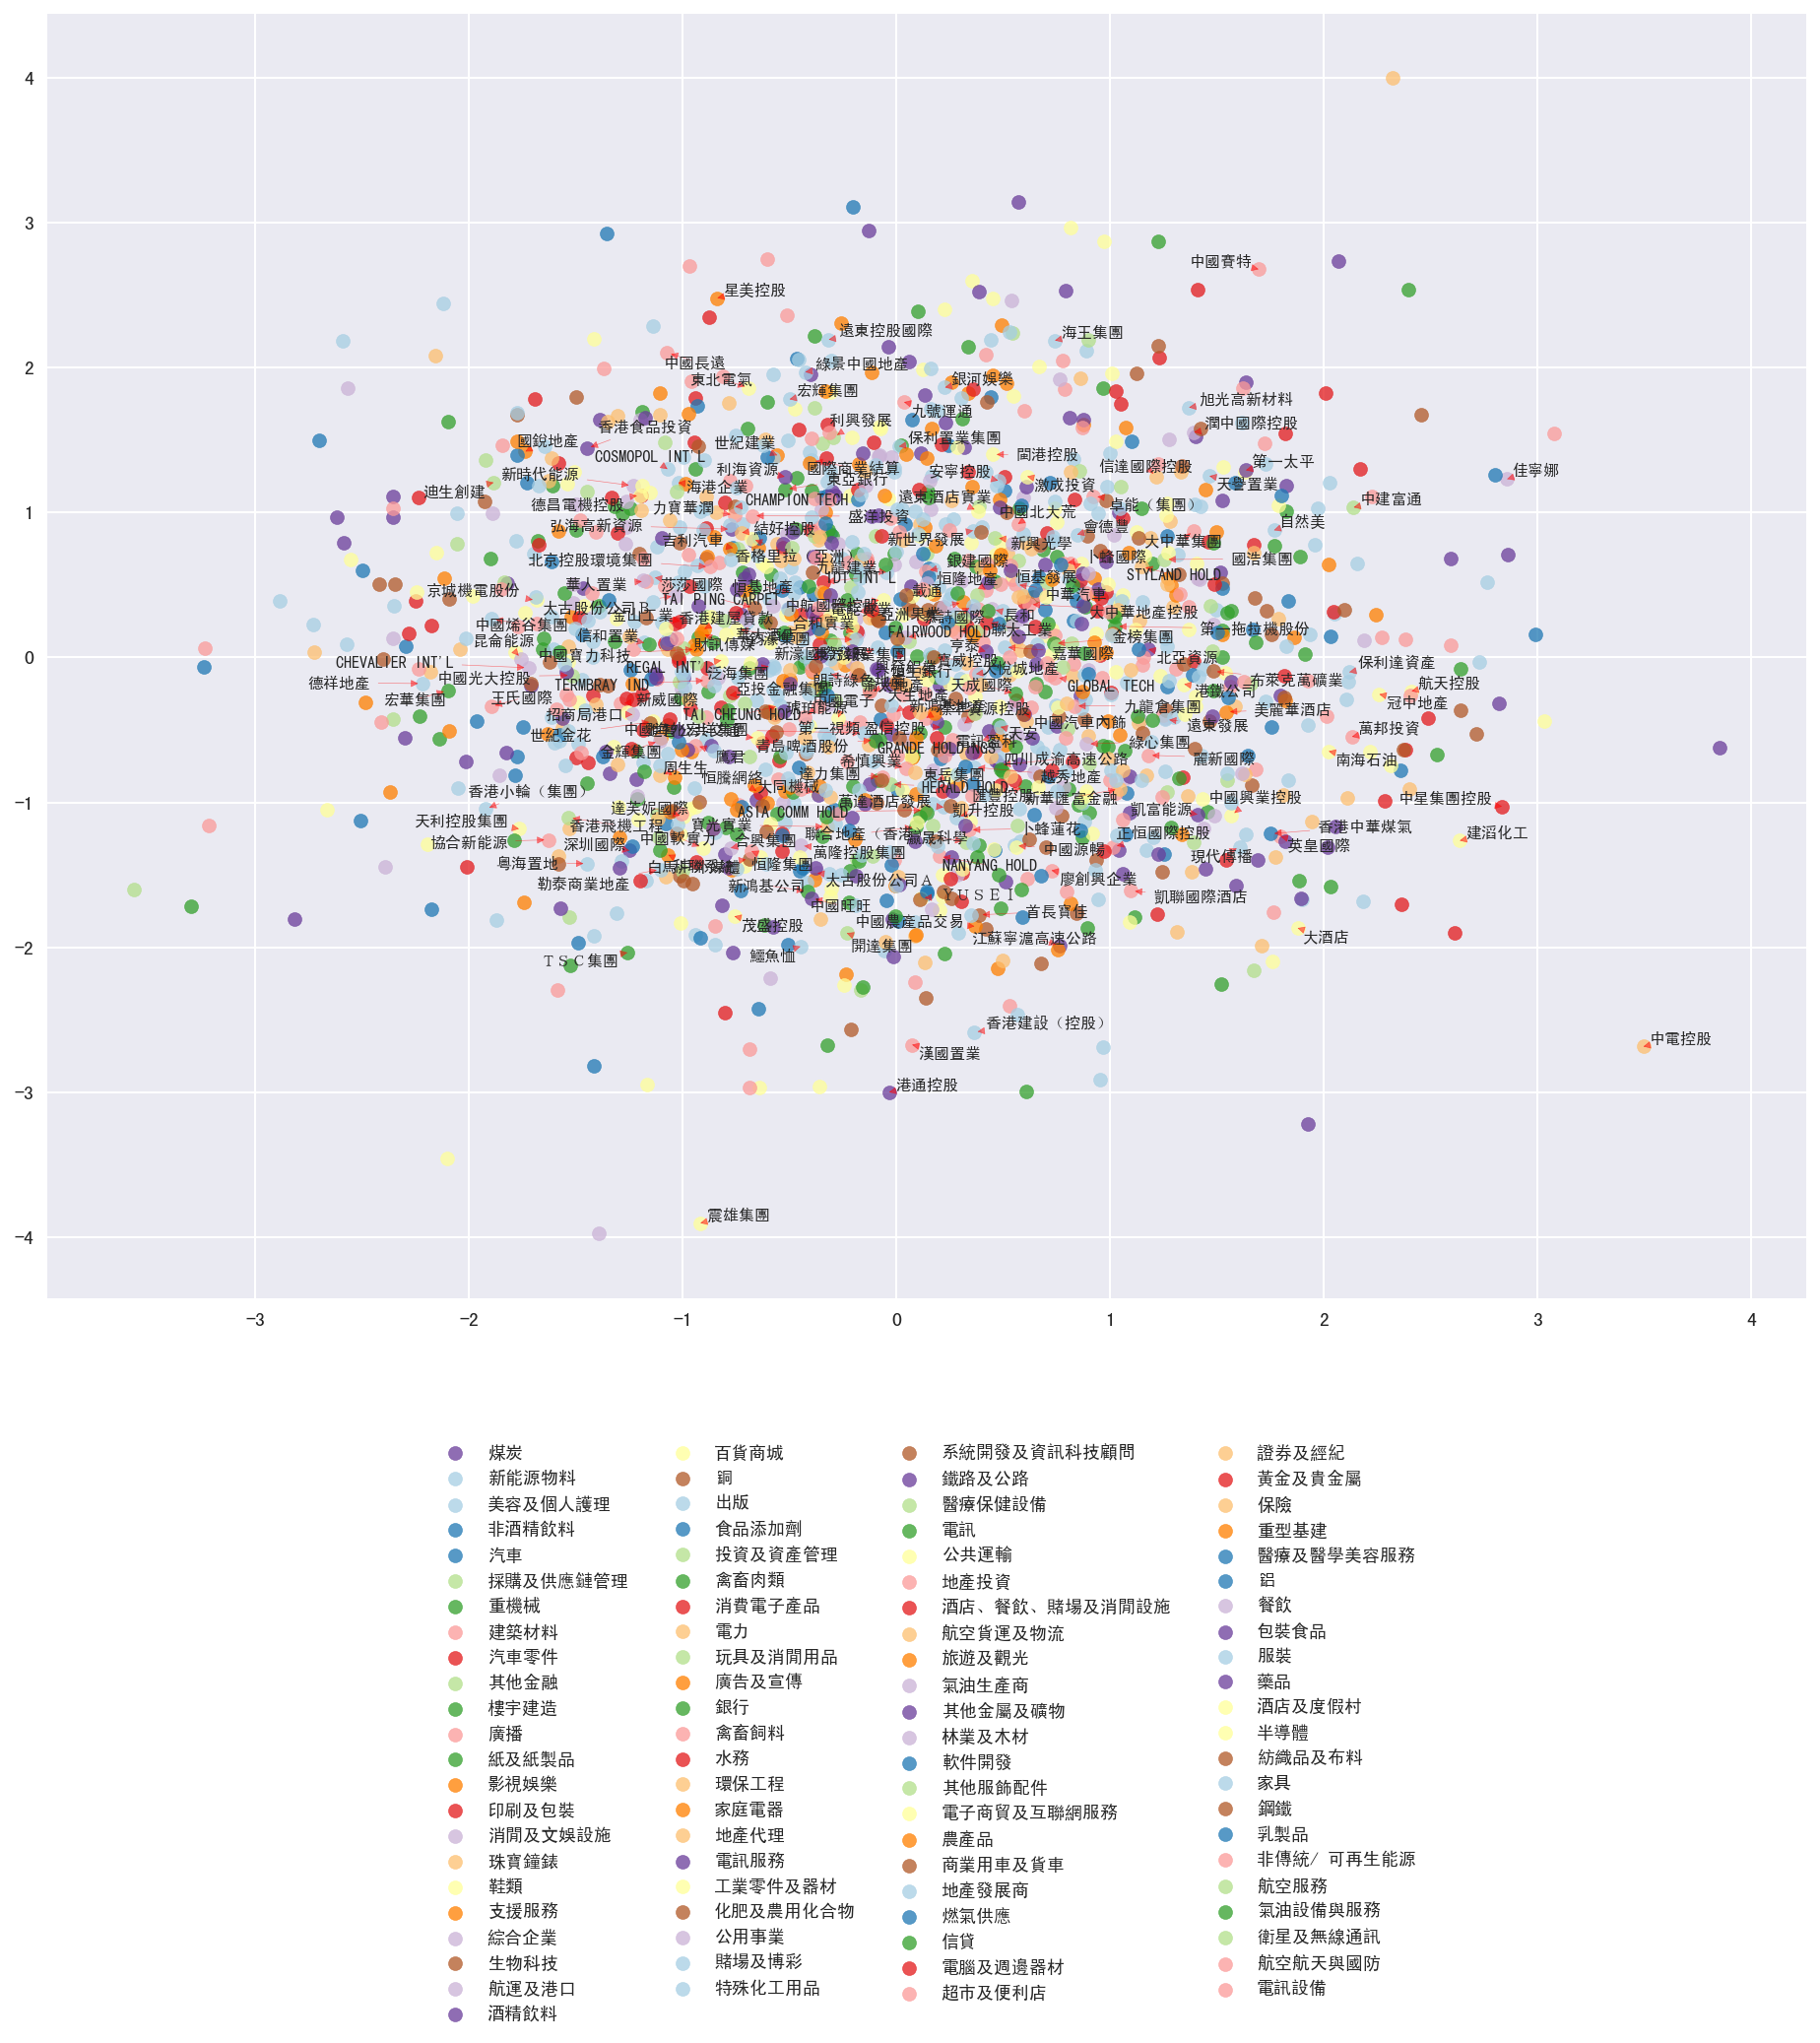

In [4]:
stock_symbols_pd = pd.read_csv('./data/list.csv', usecols=["stockCode", "stockNameZh"])
labels = json.load(open('./data/industries.json'))
stock_symbols = ["%05d" % (symbol,) for symbol in stock_symbols_pd["stockCode"]]
stock_names = [stock_name for stock_name in stock_symbols_pd["stockNameZh"]]
my_labels = set(labels.values())
colors = sns.color_palette("Paired", len(my_labels))
label_colors = dict([(label, colors[i]) for i, label in enumerate(my_labels)])
label_stocks = dict()
limit = 100

for key, value in labels.items():
    if key in stock_symbols:
        if value in label_stocks:
            label_stocks[value] += [stock_symbols.index(key)]
        else:
            label_stocks[value] = [stock_symbols.index(key)]

pca = PCA(n_components=2)
X = pca.fit_transform(embs)

# tsen = TSNE(n_components=2, perplexity=20, n_iter=500)
# X = tsen.fit_transform(embs)

xs = X[:, 0]
ys = X[:, 1]

# draw
plt.figure(figsize=(16,12))
scatters = []
annotations = []

for label, index in label_stocks.items():
    scatters.append(plt.scatter(xs[index], ys[index], marker='o', color=label_colors[label], alpha=0.75))

for i, w in enumerate(stock_names[:200]):
    annotations.append(plt.text(xs[i], ys[i], w, fontsize=8))

adjust_text(annotations, force_text=0.1, arrowprops=dict(arrowstyle="-|>", color='r', alpha=0.5))

plt.legend(scatters, list(label_stocks.keys()), scatterpoints=1, loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=4, fontsize=9)

# plt.savefig('result.png', format='png', dpi=800)
plt.show()